# 5-1. 拟时序计算

## 1. 背景

单细胞测序技术提供了生物组织的高分辨率测量[Islam等人，2011年]，[Hwang等人，2018年]。研究人员可以通过单细胞测序的方法来理解细胞异质性[Briggs等人，2018年]，[Sikkema等人，2022年]以及生物过程的动态[Jardine等人，2021年]，[He等人，2022年]。例如量化细胞命运以及识别驱动该过程的基因。然而，我们在测序的时候，细胞会直接死亡，无法再继续发育，因此，我们所获得的单细胞测序数据，如同照相机的照片一样，仅是一张快照，但是这一张快照上包含了不同时间点的细胞，因此，我们可以从这张快照上估计细胞潜在的动态过程。


拟时序根据细胞在发展过程中的各自阶段对细胞进行排序。不成熟的细胞被分配小值，成熟的细胞被分配大值。例如，研究骨髓样本时，造血干细胞被分配低拟时序值，而红细胞则被分配高拟时序值。并且，在计算拟时序时，我们通常需要指定一个初始细胞，或者叫根细胞，然后从起始点推测细胞的动态过程。

## 2. 拟时序计算

拟时序的计算通常遵循以下常见的步骤：首先，将超高维的单细胞数据投影到一个较低维度的表示上。这个过程是基于观察到的动态过程在低维流形上进行的[Wagner等人，2016年]。在实践中，拟时序的算法可能依赖于主成分（例如 Palantir [Setty等人，2019年]）或扩散成分（例如扩散伪时间（DPT）[Haghverdi等人，2016年]）。

- 1）基于树的方法：首先对观察结果进行聚类，然后识别这些聚类之间的连接。这些聚类可以被排序，从而构建伪时间。因此，我们将这种方法称为聚类方法。经典的聚类算法包括-k均值 [Lloyd, 1982年]，[MacQueen, 1967年]，Leiden [Traag等人，2019年]，或者层次聚类 [Müllner, 2011年]。聚类可以基于相似性连接，或者通过构建最小生成树（MST）[Pettie和Ramachandran，2002年]。图形方法首先找到观察结果的较低维度表示之间的连接。这个过程定义了一个图，基于这个图定义了聚类和排序。例如，PAGA [Wolf等人，2019年] 将图划分为Leiden聚类并估计它们之间的连接。直观地说，这种方法在分析数据时保留了全局拓扑，同时以较低的分辨率进行分析。因此，提高了计算效率。

- 3）基于流形学习的方法：与聚类方法类似。然而，通过使用主曲线或图来估计潜在的轨迹来定义聚类之间的连接。主曲线找到一个连接高维空间中细胞观察结果的一维曲线。这种方法的一个显著代表是 Slingshot [Street等人，2018年]。

- 4）基于状态转移概率：概率框架将转移概率分配给有序的细胞对。每个转移概率量化了参考细胞是其他细胞祖先的可能性。这些概率定义了用于定义伪时间的随机过程。例如，DPT定义为随机游走的连续状态之间的差异。相反，Palantir [Setty等人，2019年] 将轨迹本身建模为马尔可夫链。虽然这两种方法都依赖于概率框架，但需要指定一个根细胞。伪时间本身是相对于这个细胞计算的。

轨迹推断（ Trajectory Inference, TI）是一个研究充分的领域，有着超过50种方法被提出，而当我们要应用适当的方法来分析单细胞数据集，首先需要了解生物过程本身。这种理解尤其包括过程的性质，例如，它是否是线性的、循环的或分支的。为了帮助识别适当的工具，dynguidelines [Deconinck等人，2021年] 提供了算法及其特性的详尽概览。

在本章教程中，我们将尝试不同的拟时序算法，并观察他们之间的差异。

In [1]:
import omicverse as ov
import scanpy as sc
import scvelo as scv

ov.plot_set()


   ____            _     _    __                  
  / __ \____ ___  (_)___| |  / /__  _____________ 
 / / / / __ `__ \/ / ___/ | / / _ \/ ___/ ___/ _ \ 
/ /_/ / / / / / / / /__ | |/ /  __/ /  (__  )  __/ 
\____/_/ /_/ /_/_/\___/ |___/\___/_/  /____/\___/                                              

Version: 1.5.9, Tutorials: https://omicverse.readthedocs.io/


Global seed set to 0


## 3. 加载数据

在本教程中，我们将使用小鼠齿状回神经元的单细胞RNA-seq测序数据，进而研究nIPC的分化过程。

In [2]:
import scvelo as scv
adata=scv.datasets.dentategyrus()
adata

AnnData object with n_obs × n_vars = 2930 × 13913
    obs: 'clusters', 'age(days)', 'clusters_enlarged'
    uns: 'clusters_colors'
    obsm: 'X_umap'
    layers: 'ambiguous', 'spliced', 'unspliced'

我们使用omicverse自带的预处理函数，并且我们选择前3000个基因作为高可变基因。

In [3]:
adata=ov.pp.preprocess(adata,mode='shiftlog|pearson',n_HVGs=3000,)
adata.raw = adata
adata = adata[:, adata.var.highly_variable_features]
ov.pp.scale(adata)
ov.pp.pca(adata,layer='scaled',n_pcs=50)

Begin robust gene identification
After filtration, 13264/13913 genes are kept. Among 13264 genes, 13189 genes are robust.
End of robust gene identification.
Begin size normalization: shiftlog and HVGs selection pearson
normalizing counts per cell The following highly-expressed genes are not considered during normalization factor computation:
['Hba-a1', 'Malat1', 'Ptgds', 'Hbb-bt']
    finished (0:00:00)
extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'highly_variable_nbatches', int vector (adata.var)
    'highly_variable_intersection', boolean vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'residual_variances', float vector (adata.var)
End of size normalization: shiftlog and HVGs selection pearson
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


让我们检查单个主成分（PC）对数据总方差的贡献。这为我们提供了关于我们应该考虑多少个主成分来计算细胞之间邻域关系的信息。根据我们的经验，通常粗略估计主成分的数量就可以满足需求。一般而言前50个主成分即涵盖大部分的数据变异性。

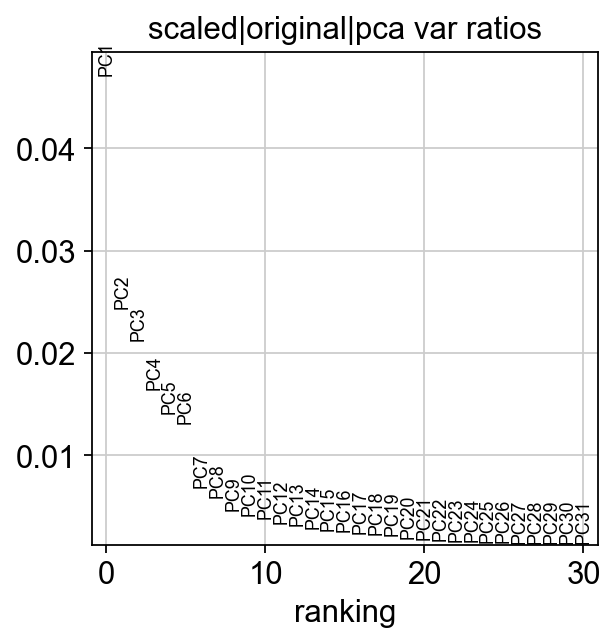

In [4]:
ov.utils.plot_pca_variance_ratio(adata)

## 4. 基于PAGA的扩散模型

基于分区的图抽象（PAGA）基于估计流形分区的连通性，为产生的数据流形提供了一个可解释的类似图的映射(https://github.com/theislab/paga) 。PAGA映射保留了数据的全局拓扑，允许以不同的分辨率分析数据，并显著提高了典型探索性数据分析工作流的计算效率。我们在这里，使用Omicverse来调用该函数，需要注意的是，PAGA模型需要预先定义发育的起点。

In [5]:
Traj=ov.single.TrajInfer(adata,basis='X_umap',use_rep='scaled|original|X_pca',n_comps=50)
Traj.set_origin_cells('nIPC')
Traj.inference(method='diffusion_map')

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:04)
computing Diffusion Maps using n_comps=15(=n_dcs)
computing transitions
    finished (0:00:00)
    eigenvalues of transition matrix
    [1.         0.9997221  0.99916786 0.9990551  0.99901944 0.99856067
     0.9955311  0.9947327  0.9926525  0.9906649  0.97991765 0.97849923
     0.9777416  0.97599846 0.9694986 ]
    finished: added
    'X_diffmap', diffmap coordinates (adata.obsm)
    'diffmap_evals', eigenvalues of transition matrix (adata.uns) (0:00:00)
computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
drawing single-cell graph using layout 'fa'
    finished: added
    'X_draw_graph_fr', graph_drawing coordinates (adata.obsm) (0:00:08)
computing Diffusion

我们可以可视化每个细胞的拟时序值，进而观察细胞的发育过程。

In [18]:
import numpy as np
adata.obs['dpt_pseudotime']=adata.obs['dpt_pseudotime'].fillna(0)
adata.obs['dpt_pseudotime'].replace([np.inf], 1, inplace=True)
adata.obs['dpt_pseudotime'].replace([-np.inf], 0, inplace=True)

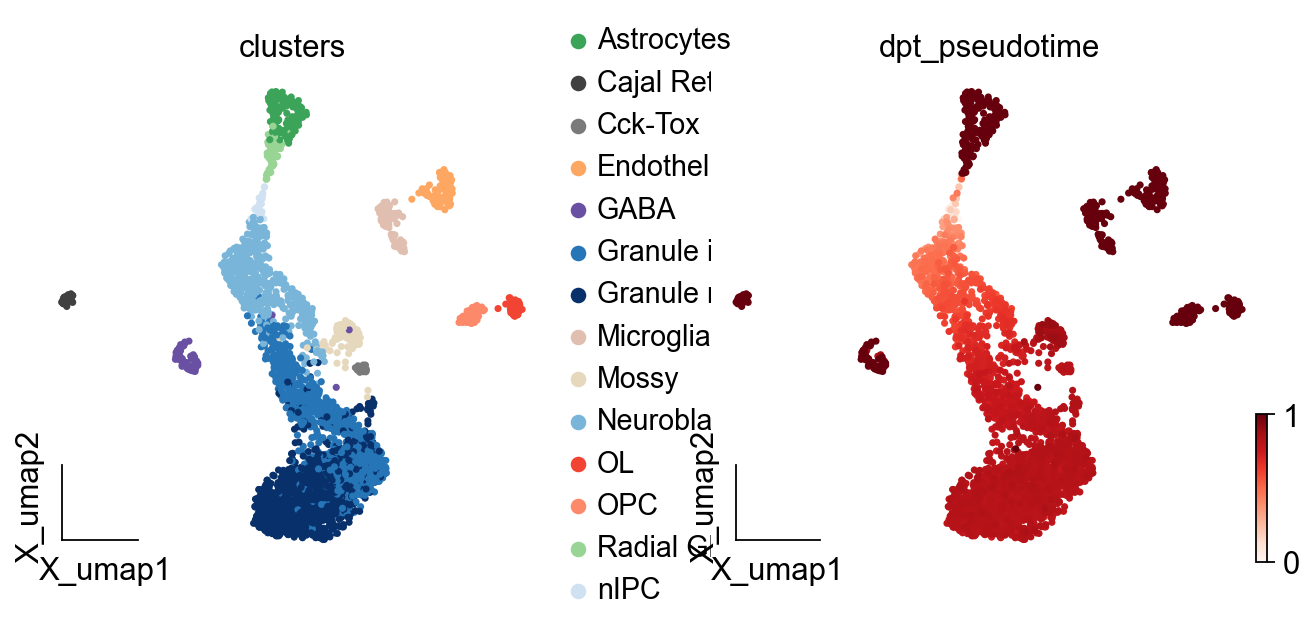

In [24]:
ov.pl.embedding(adata,basis='X_umap',
                   color=['clusters','dpt_pseudotime'],
                   frameon='small',cmap='Reds')

此外，我们还可以研究分配给每个单元类型簇的伪时间值的分布，而不是给数据的低维表示着色。

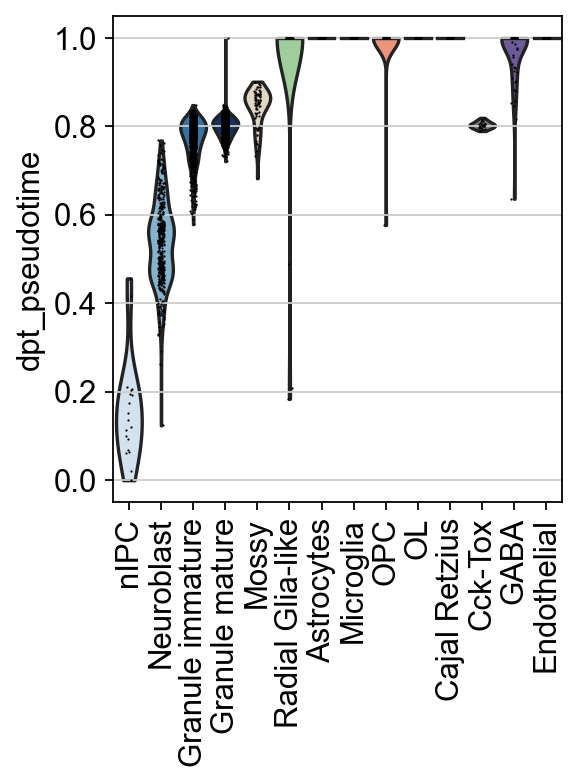

In [21]:
sc.pl.violin(
    adata,
    keys=["dpt_pseudotime"],
    groupby="clusters",
    rotation=90,
    order=[
        "nIPC",
        "Neuroblast",
        "Granule immature",
        "Granule mature",
        "Mossy",
        "Radial Glia-like",
        "Astrocytes",
        "Microglia",
        "OPC",
        "OL",
        'Cajal Retzius', 'Cck-Tox',"GABA","Endothelial"
    ],
)

我们还可以计算每一类细胞类型转换的状态转移概率矩阵，PAGA 图的抽象被标准化为轨迹推理的最佳方法。它提供了一个数据拓扑的图形化映射，其加权边对应于两个簇之间的连通性。

这里，PAGA 是由邻域方向性扩展的。

running PAGA using priors: ['dpt_pseudotime']
    finished
added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns)
    'paga/transitions_confidence', velocity transitions (adata.uns)


<AxesSubplot: title={'center': 'PAGA LTNN-graph'}>

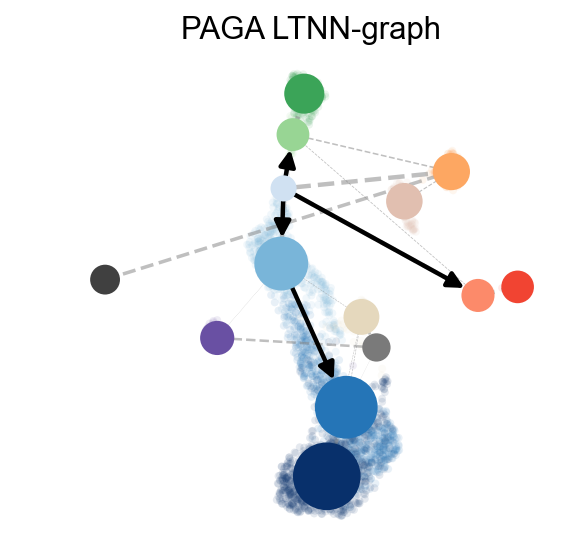

In [23]:
ov.utils.cal_paga(adata,use_time_prior='dpt_pseudotime',vkey='paga',
                 groups='clusters')
ov.utils.plot_paga(adata,basis='umap', size=50, alpha=.1,title='PAGA LTNN-graph',
            min_edge_width=2, node_size_scale=1.5,show=False,legend_loc=False)

## 5. 基于流形学习的轨迹推断

Slingshot是一个独特的健壮和灵活的工具，它结合了高度稳定的技术必要的噪声单细胞数据和能力，以确定多个轨迹。

In [25]:
Traj=ov.single.TrajInfer(adata,basis='X_umap',use_rep='scaled|original|X_pca',n_comps=50)
Traj.set_origin_cells('nIPC')
Traj.inference(method='slingshot',num_epochs=1)

Lineages: [Lineage[13, 9, 5, 2, 8], Lineage[13, 9, 5, 2, 7, 3], Lineage[13, 9, 5, 4, 1], Lineage[13, 9, 5, 6, 11, 10], Lineage[13, 12, 0]]


  0%|          | 0/1 [00:00<?, ?it/s]

Reversing from leaf to root
Averaging branch @2 with lineages: [0, 1] [<pcurvepy2.pcurve.PrincipalCurve object at 0x7f0d41d076a0>, <pcurvepy2.pcurve.PrincipalCurve object at 0x7f0d41d07460>]
Averaging branch @5 with lineages: [0, 1, 2, 3] [<pcurvepy2.pcurve.PrincipalCurve object at 0x7f0d41d07a00>, <pcurvepy2.pcurve.PrincipalCurve object at 0x7f0d41d20640>, <pcurvepy2.pcurve.PrincipalCurve object at 0x7f0d41d07a60>]
Averaging branch @13 with lineages: [0, 1, 2, 3, 4] [<pcurvepy2.pcurve.PrincipalCurve object at 0x7f0d41d07580>, <pcurvepy2.pcurve.PrincipalCurve object at 0x7f0d41d20af0>]
Shrinking branch @13 with curves: [<pcurvepy2.pcurve.PrincipalCurve object at 0x7f0d41d07580>, <pcurvepy2.pcurve.PrincipalCurve object at 0x7f0d41d20af0>]
Shrinking branch @5 with curves: [<pcurvepy2.pcurve.PrincipalCurve object at 0x7f0d41d07a00>, <pcurvepy2.pcurve.PrincipalCurve object at 0x7f0d41d20640>, <pcurvepy2.pcurve.PrincipalCurve object at 0x7f0d41d07a60>]
Shrinking branch @2 with curves: [<pcu

如果你想可视化流形学习的训练过程，你也可以设置`debug_axes`参数

Lineages: [Lineage[13, 9, 5, 2, 8], Lineage[13, 9, 5, 2, 7, 3], Lineage[13, 9, 5, 4, 1], Lineage[13, 9, 5, 6, 11, 10], Lineage[13, 12, 0]]


  0%|          | 0/1 [00:00<?, ?it/s]

Reversing from leaf to root
Averaging branch @2 with lineages: [0, 1] [<pcurvepy2.pcurve.PrincipalCurve object at 0x7f0d41d67940>, <pcurvepy2.pcurve.PrincipalCurve object at 0x7f0d41ee3c70>]
Averaging branch @5 with lineages: [0, 1, 2, 3] [<pcurvepy2.pcurve.PrincipalCurve object at 0x7f0d41ee3940>, <pcurvepy2.pcurve.PrincipalCurve object at 0x7f0d42305c40>, <pcurvepy2.pcurve.PrincipalCurve object at 0x7f0d41ee39d0>]
Averaging branch @13 with lineages: [0, 1, 2, 3, 4] [<pcurvepy2.pcurve.PrincipalCurve object at 0x7f0d42305e50>, <pcurvepy2.pcurve.PrincipalCurve object at 0x7f0d41ee3970>]
Shrinking branch @13 with curves: [<pcurvepy2.pcurve.PrincipalCurve object at 0x7f0d42305e50>, <pcurvepy2.pcurve.PrincipalCurve object at 0x7f0d41ee3970>]
Shrinking branch @5 with curves: [<pcurvepy2.pcurve.PrincipalCurve object at 0x7f0d41ee3940>, <pcurvepy2.pcurve.PrincipalCurve object at 0x7f0d42305c40>, <pcurvepy2.pcurve.PrincipalCurve object at 0x7f0d41ee39d0>]
Shrinking branch @2 with curves: [<pcu

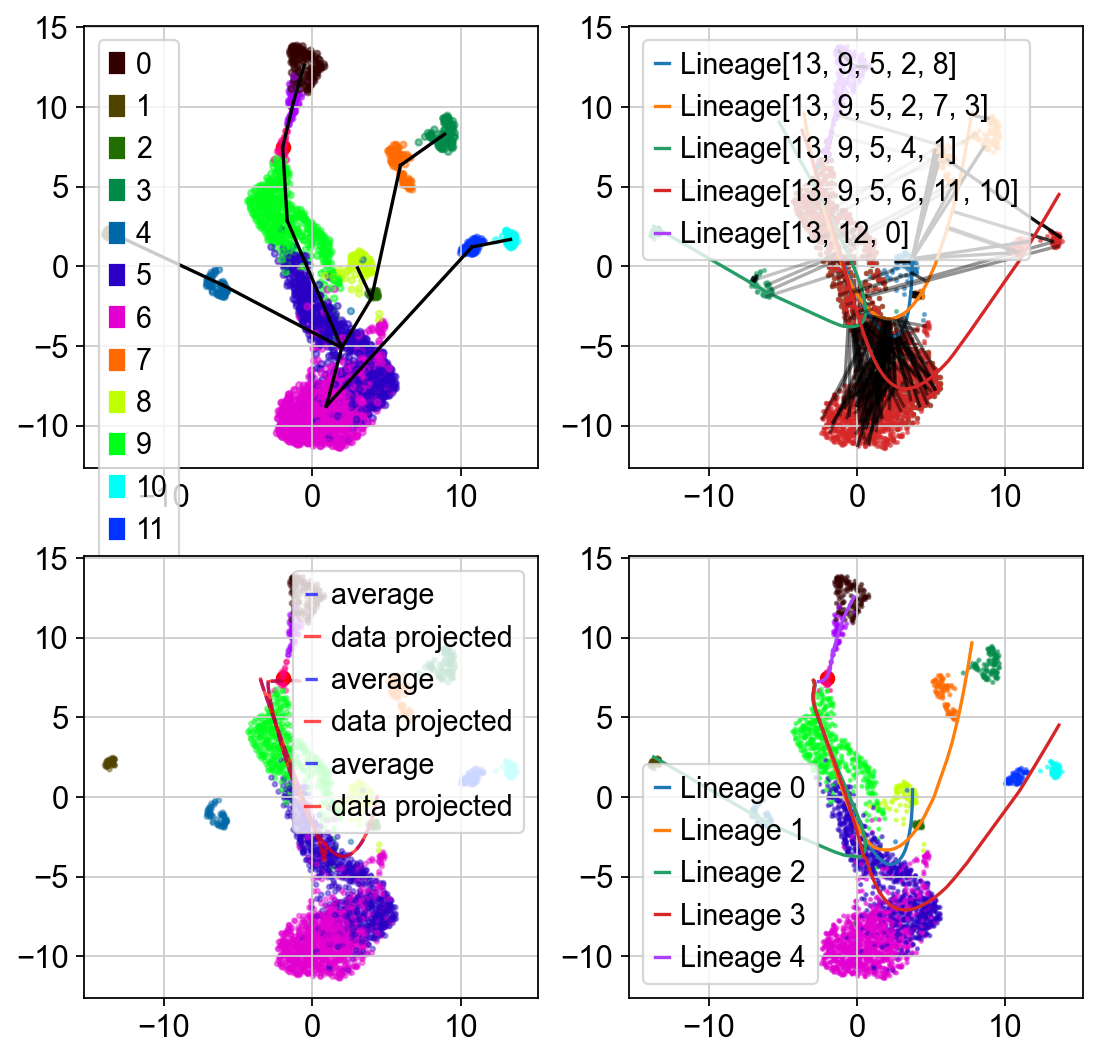

In [27]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(8, 8))
Traj.inference(method='slingshot',num_epochs=1,debug_axes=axes)

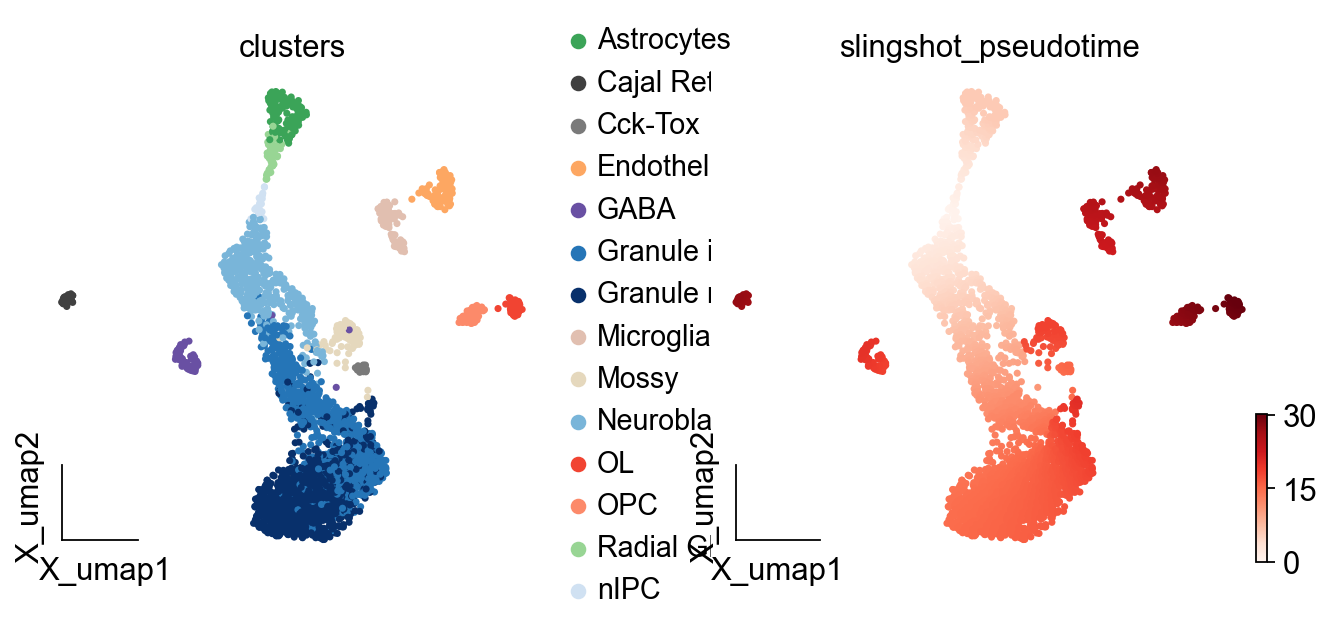

In [28]:
ov.pl.embedding(adata,basis='X_umap',
                   color=['clusters','slingshot_pseudotime'],
                   frameon='small',cmap='Reds')

running PAGA using priors: ['slingshot_pseudotime']
    finished
added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns)
    'paga/transitions_confidence', velocity transitions (adata.uns)


<AxesSubplot: title={'center': 'PAGA Slingshot-graph'}>

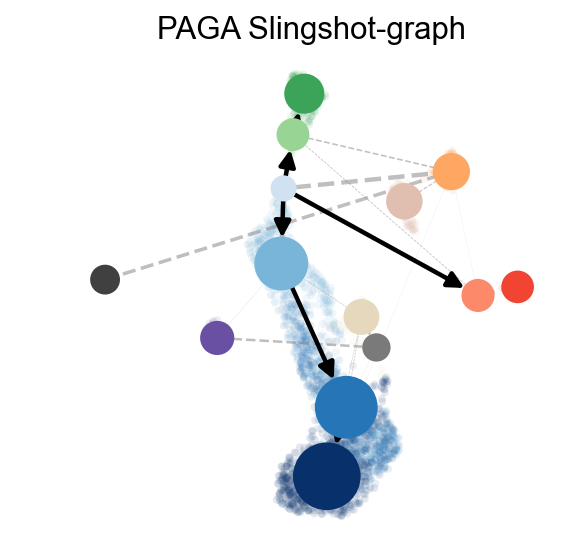

In [30]:
ov.utils.cal_paga(adata,use_time_prior='slingshot_pseudotime',vkey='paga',
                 groups='clusters')
ov.utils.plot_paga(adata,basis='umap', size=50, alpha=.1,title='PAGA Slingshot-graph',
            min_edge_width=2, node_size_scale=1.5,show=False,legend_loc=False)

## 6. 基于状态转移概率的轨迹推断（一）

我们还可以使用一些基于状态转移的模型，例如基于马尔可夫链的Palantir，需要注意的是，Palantir模型的使用除了定义起点外，还需要定义终点。

In [31]:
Traj=ov.single.TrajInfer(adata,basis='X_umap',use_rep='scaled|original|X_pca',n_comps=50)
Traj.set_origin_cells('nIPC')
Traj.set_terminal_cells(["Granule mature","OL","Astrocytes"])
Traj.inference(method='palantir',num_waypoints=500)

Time for shortest paths: 0.2642598867416382 minutes
Iteratively refining the pseudotime...
Correlation at iteration 1: 0.9998
Correlation at iteration 2: 0.9999
Entropy and branch probabilities...
Markov chain construction...
Computing fundamental matrix and absorption probabilities...
Project results to all cells...


Palantir也有自己的可视化方法，我们可以观察不同轨迹的独立拟时序值。

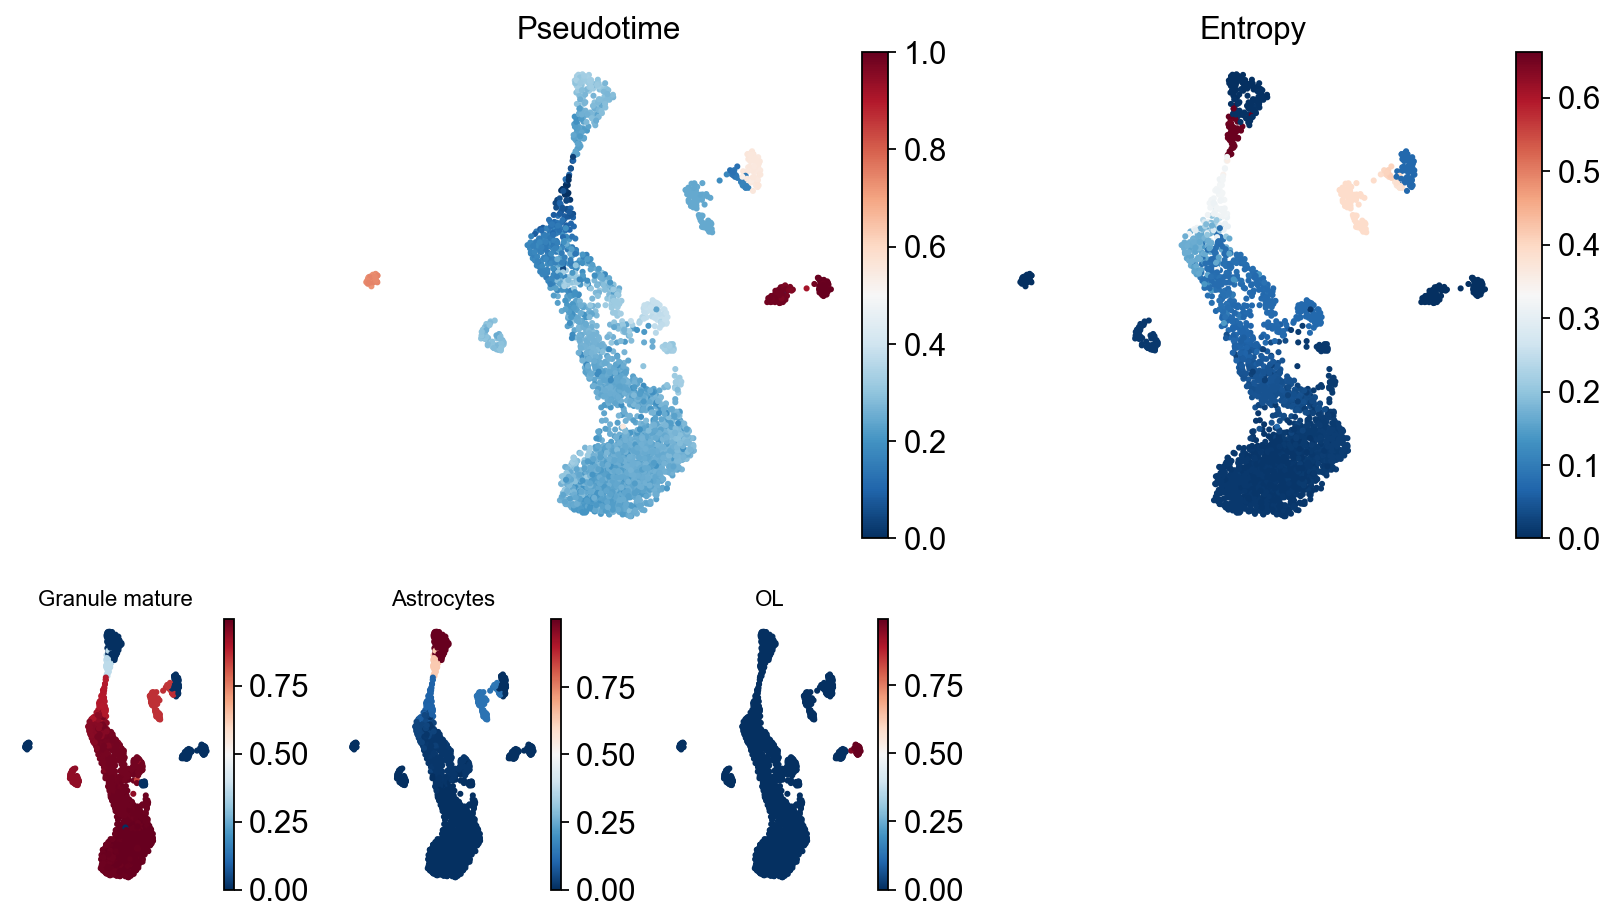

In [32]:
Traj.palantir_plot_pseudotime(embedding_basis='X_umap',cmap='RdBu_r',s=3)

一旦细胞被选中，通常有助于可视化选择的假时间轨迹，以确保我们已经分离出正确的细胞，我们的具体趋势。我们可以使用 plot_Branch_select 函数来完成这项工作:

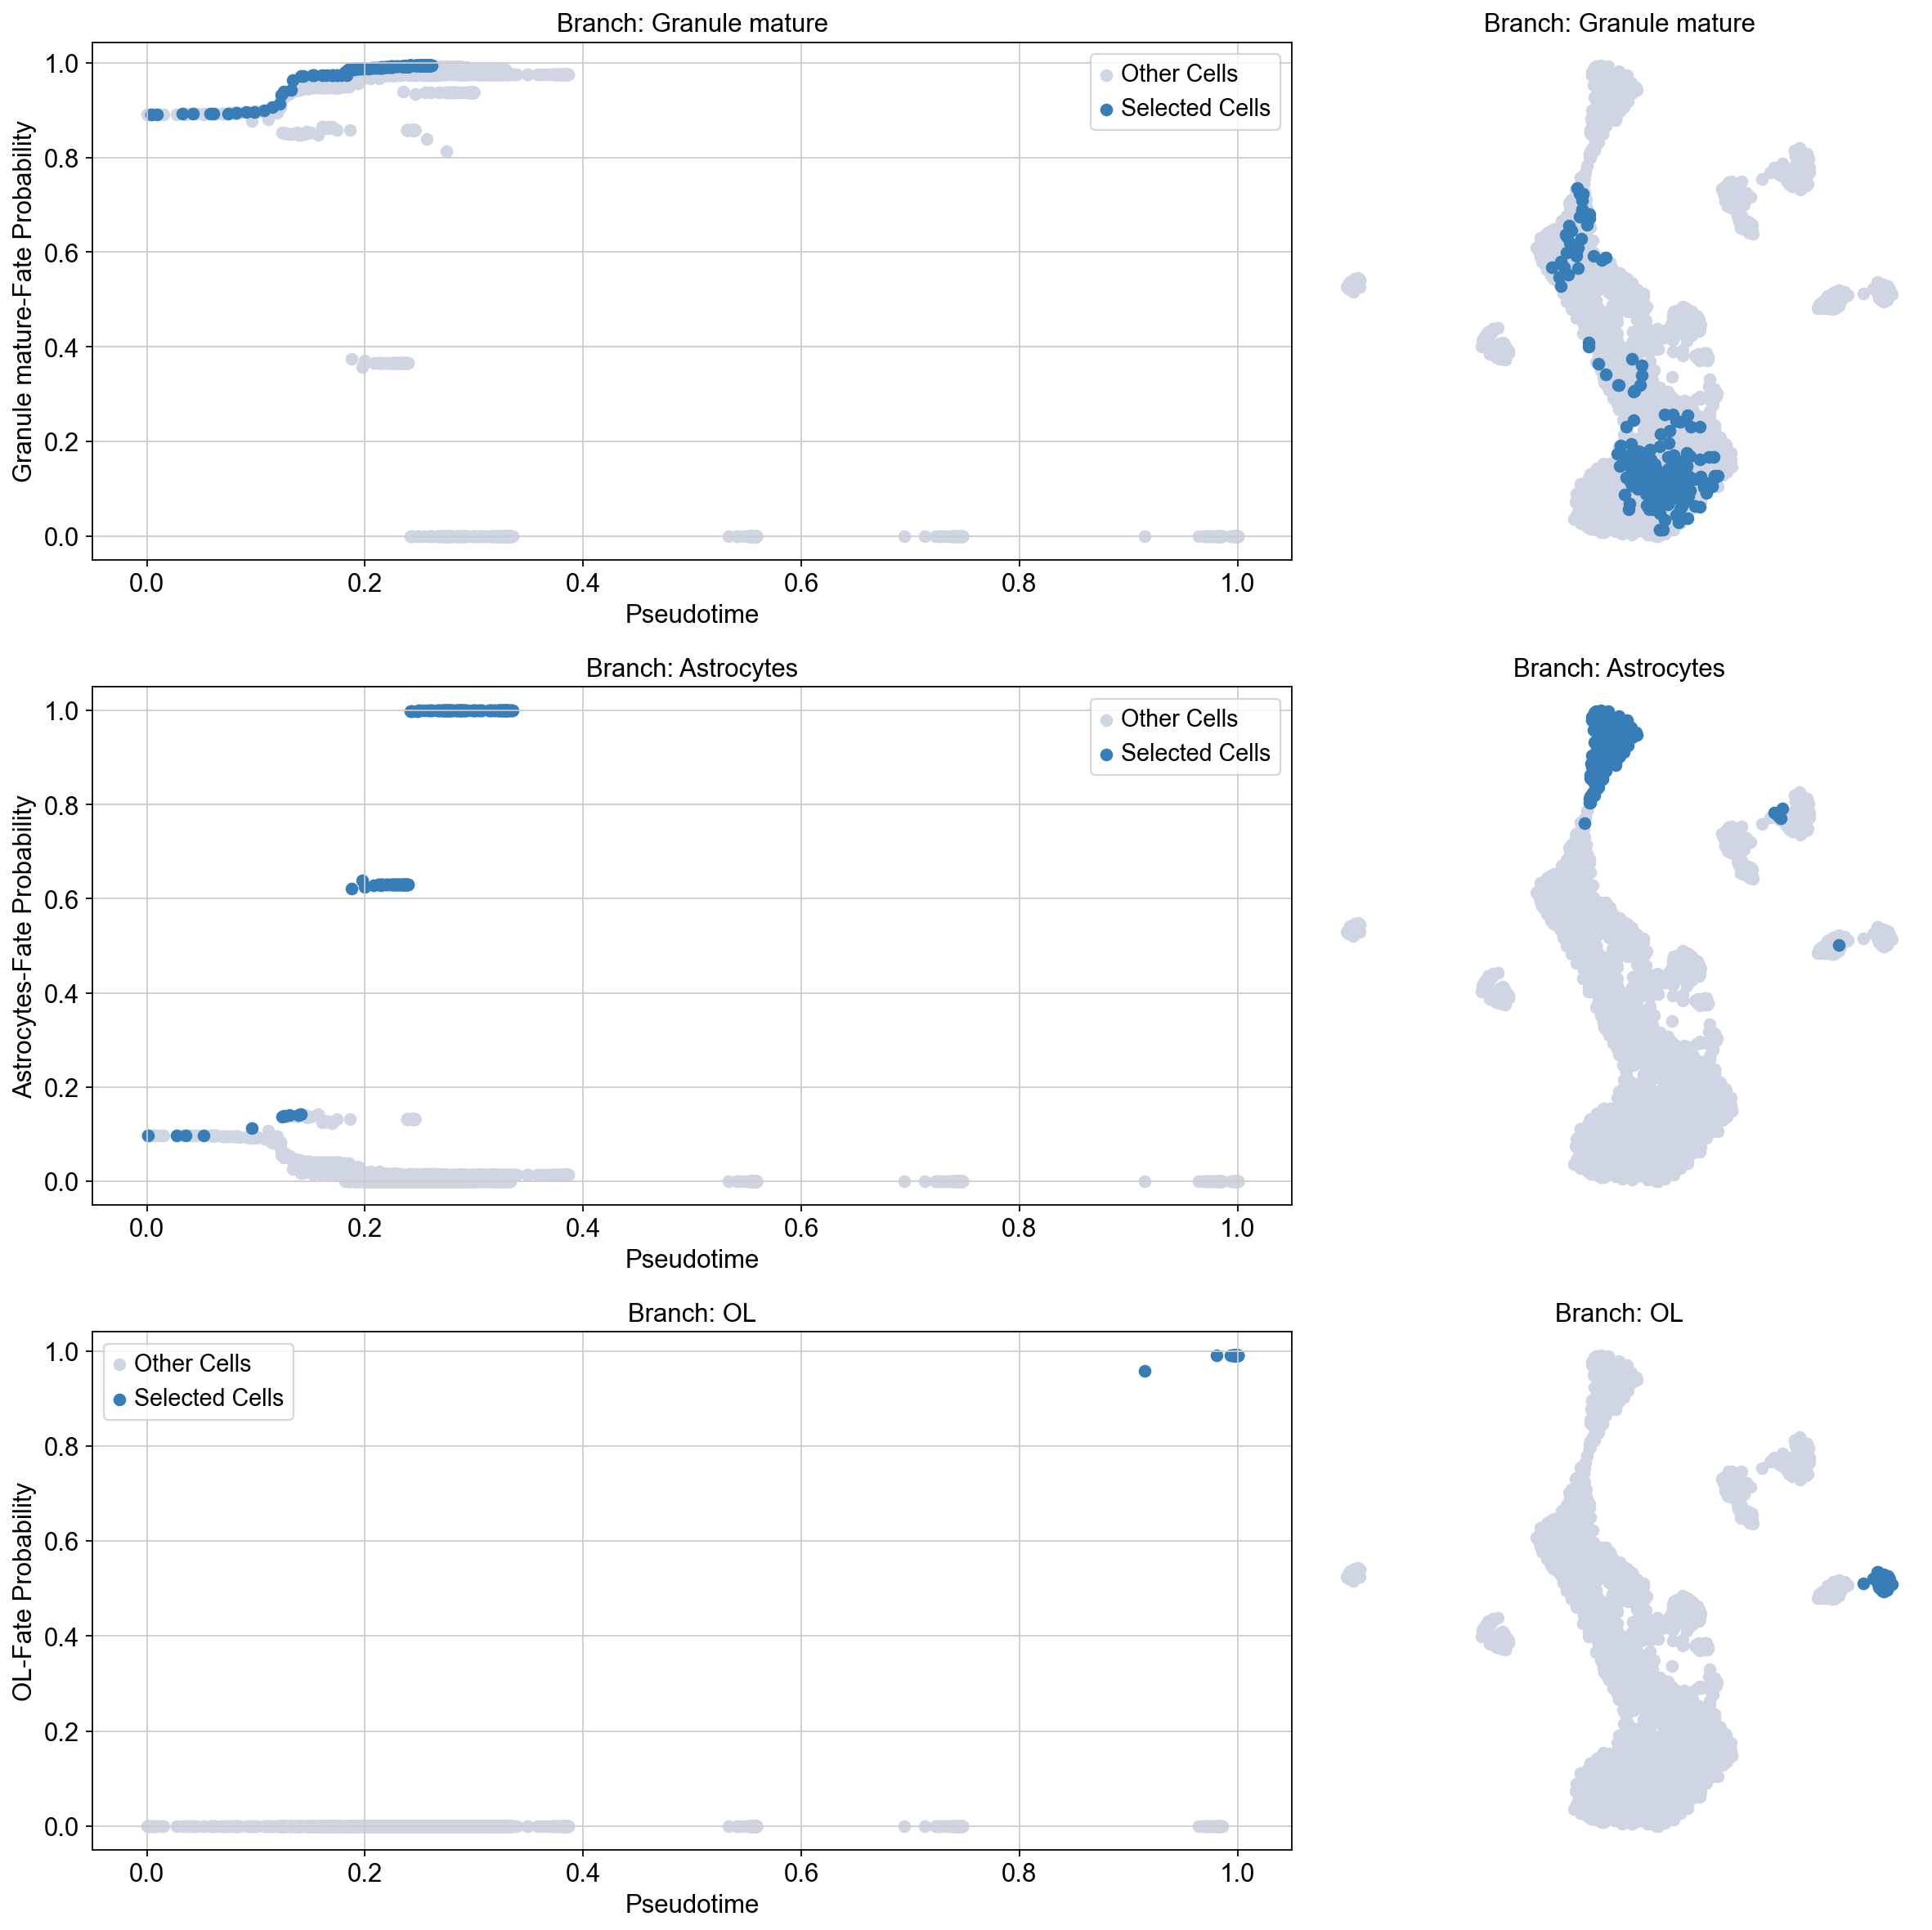

In [33]:
Traj.palantir_cal_branch(eps=0)

[2024-04-05 14:15:43,020] [INFO    ] Using covariance function Matern52(ls=1.8777667989311575).
[2024-04-05 14:15:44,039] [INFO    ] Computing 50 landmarks with k-means clustering.


<AxesSubplot: title={'center': 'Branch: Granule mature'}, xlabel='UMAP1', ylabel='UMAP2'>

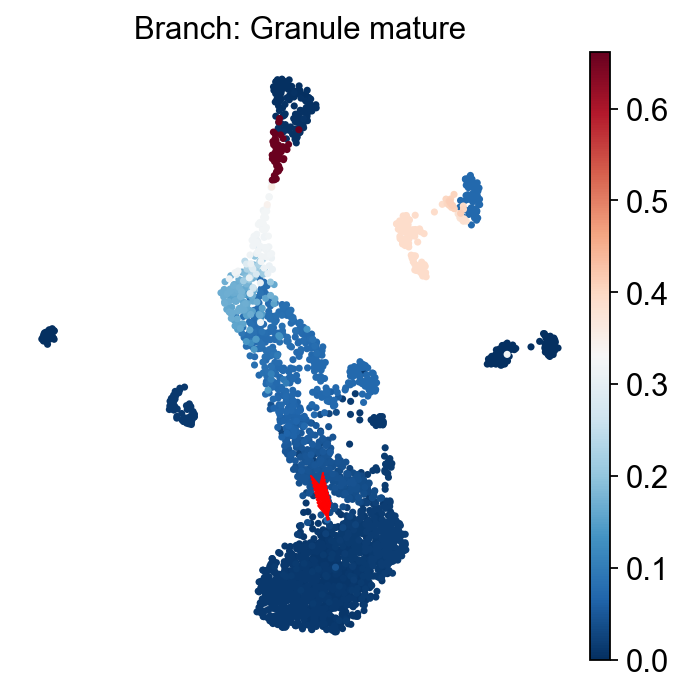

In [34]:
ov.palantir.plot.plot_trajectory(adata, "Granule mature",
                                cell_color="palantir_entropy",
                                n_arrows=10,
                                color="red",
                                scanpy_kwargs=dict(cmap="RdBu_r"),
                                )

running PAGA using priors: ['palantir_pseudotime']
    finished
added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns)
    'paga/transitions_confidence', velocity transitions (adata.uns)


<AxesSubplot: title={'center': 'PAGA Slingshot-graph'}>

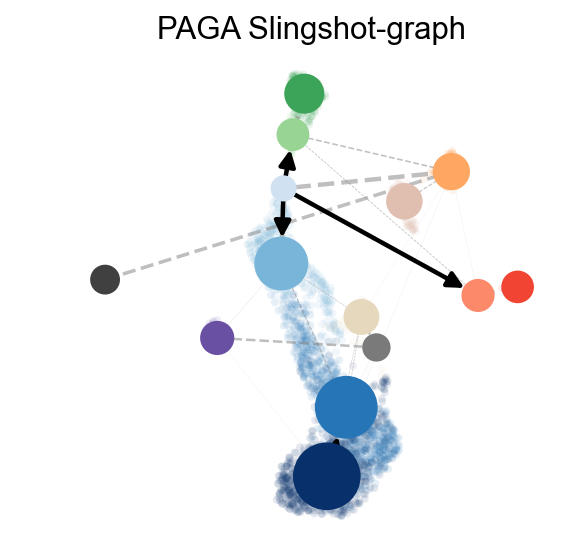

In [35]:
ov.utils.cal_paga(adata,use_time_prior='palantir_pseudotime',vkey='paga',
                 groups='clusters')
ov.utils.plot_paga(adata,basis='umap', size=50, alpha=.1,title='PAGA Slingshot-graph',
            min_edge_width=2, node_size_scale=1.5,show=False,legend_loc=False)

## 7. 基于状态转移概率的轨迹推断（二）

VIA（Vector field Integration Approach）是一个单细胞轨迹推断方法，提供拓扑结构构建、伪时间、自动终端状态预测以及沿谱系的时间基因动态的自动绘图。在这里，我们改进了原始作者的着色逻辑和用户习惯，以便用户可以直接使用anndata对象进行分析。

我们已经完成了这个教程，使用了原始VIA作者提供的分析。

论文：Generalized and scalable trajectory inference in single-cell omics data with VIA

In [41]:
v0 = ov.single.pyVIA(adata=adata,adata_key='scaled|original|X_pca',
                     adata_ncomps=50, basis='X_umap',
                         clusters='clusters',knn=15,random_seed=4,
                    root_user=['nIPC'],)

v0.run()

2024-04-05 14:59:43.619116	Running VIA over input data of 2930 (samples) x 50 (features)
2024-04-05 14:59:43.619149	Knngraph has 15 neighbors
2024-04-05 14:59:44.570910	Finished global pruning of 15-knn graph used for clustering at level of 0.15. Kept 41.8 % of edges. 
2024-04-05 14:59:44.579588	Number of connected components used for clustergraph  is 1
2024-04-05 14:59:44.623012	Commencing community detection
2024-04-05 14:59:44.769569	Finished running Leiden algorithm. Found 646 clusters.
2024-04-05 14:59:44.770397	Merging 615 very small clusters (<10)
2024-04-05 14:59:44.776068	Finished detecting communities. Found 31 communities
2024-04-05 14:59:44.776271	Making cluster graph. Global cluster graph pruning level: 0.15
2024-04-05 14:59:44.780383	Graph has 1 connected components before pruning
2024-04-05 14:59:44.781876	Graph has 14 connected components after pruning
2024-04-05 14:59:44.789530	Graph has 1 connected components after reconnecting
2024-04-05 14:59:44.789928	0.0% links tr

In [42]:
#you can use `v0.model.single_cell_pt_markov` to extract the pseudotime
v0.get_pseudotime(adata)
adata.obs['via_pseudotime']=adata.obs['pt_via'].copy()

...the pseudotime of VIA added to AnnData obs named `pt_via`


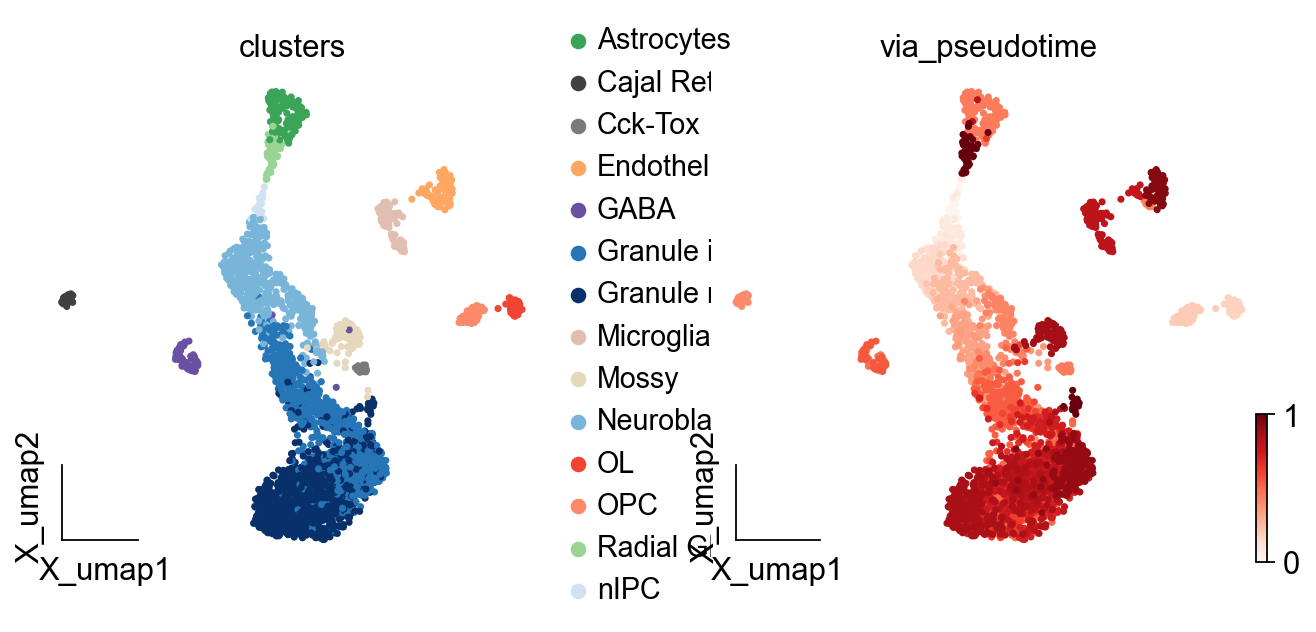

In [43]:
ov.pl.embedding(adata,basis='X_umap',
                   color=['clusters','via_pseudotime'],
                   frameon='small',cmap='Reds')

running PAGA using priors: ['via_pseudotime']
    finished
added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns)
    'paga/transitions_confidence', velocity transitions (adata.uns)


<AxesSubplot: title={'center': 'PAGA VIA-graph'}>

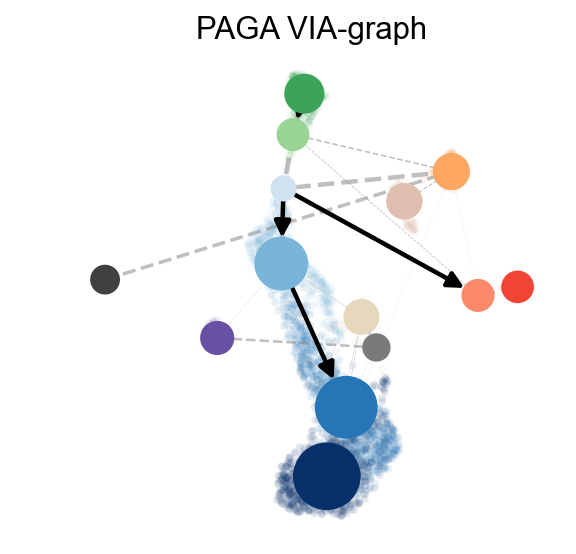

In [44]:
ov.utils.cal_paga(adata,use_time_prior='via_pseudotime',vkey='paga',
                 groups='clusters')
ov.utils.plot_paga(adata,basis='umap', size=50, alpha=.1,title='PAGA VIA-graph',
            min_edge_width=2, node_size_scale=1.5,show=False,legend_loc=False)

## 8. 不同拟时序算法的对比

我们在本章介绍了四种具有代表性的拟时序值计算算法，但是，这些算法均没有考虑到类似于真实细胞时间，RNA剪接速率等，因此，我们在下一章的分析，将介绍另一种基于RNA速率的算法思想以及代表算法。

我们除了通过每个细胞的拟时序值来可视化细胞的拟时序状态，我们还可以观察拟时序值在不同细胞类型的分布进而去研究不同算法的好坏。

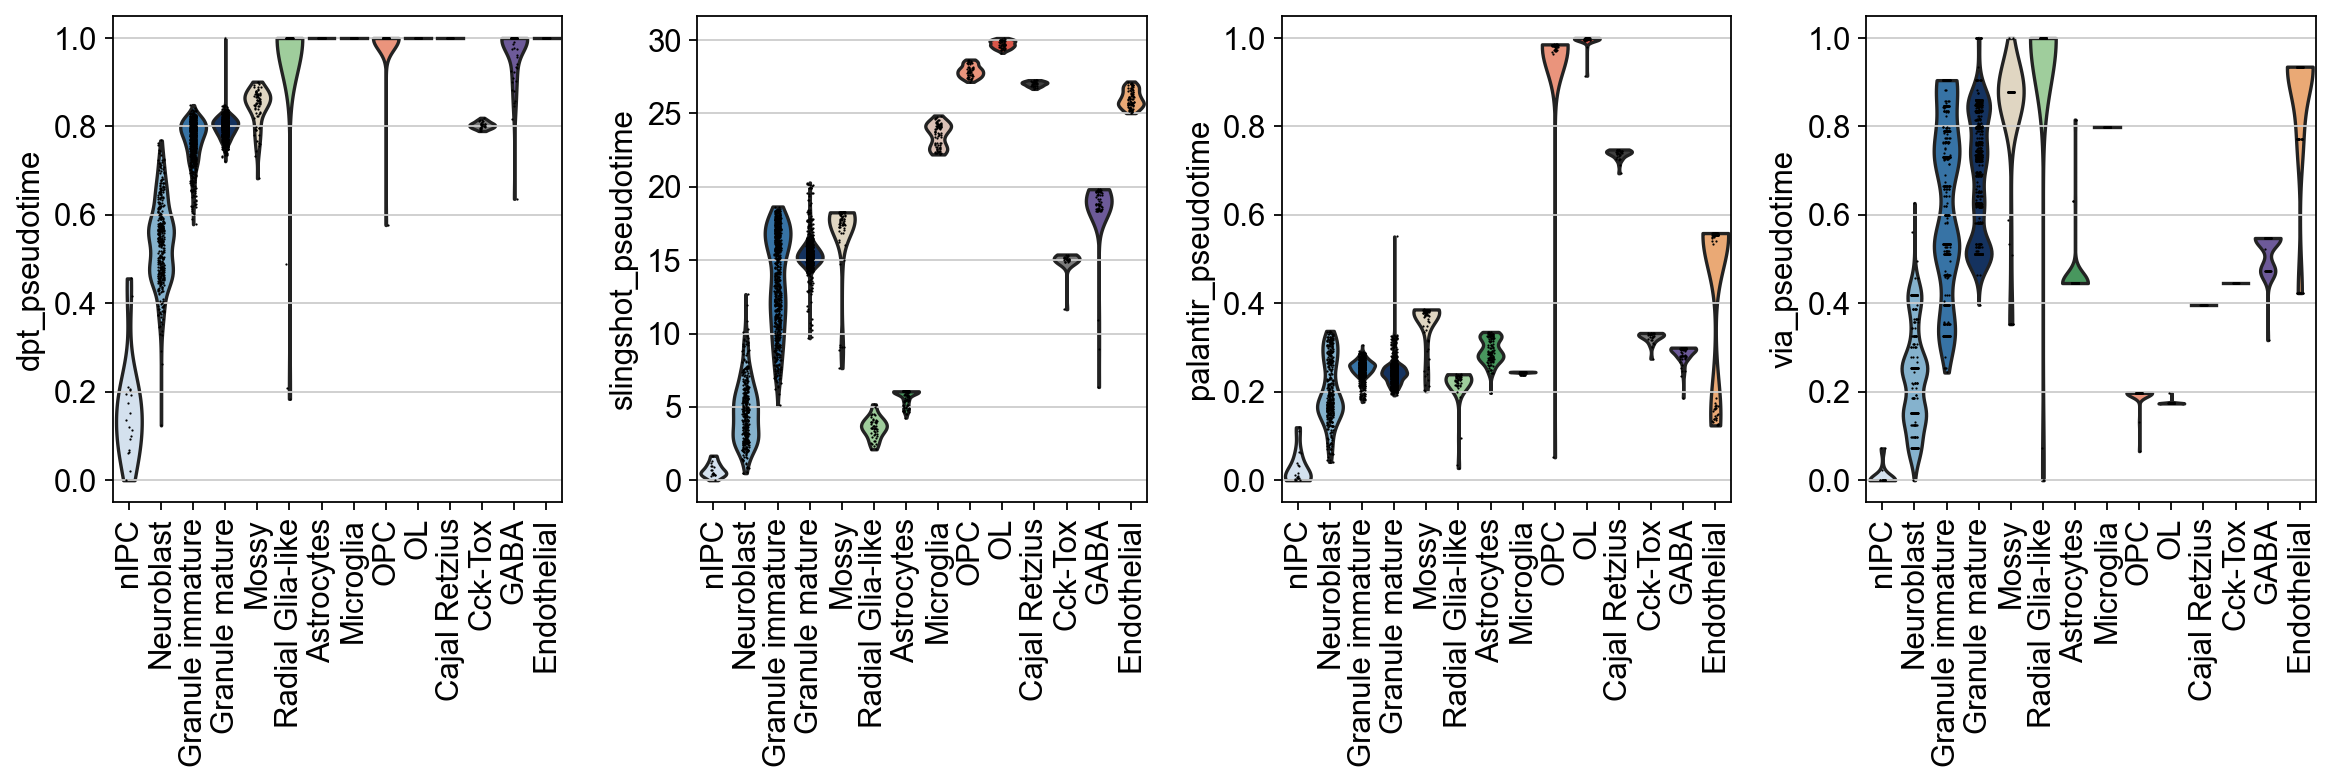

In [45]:
sc.pl.violin(
    adata,
    keys=["dpt_pseudotime","slingshot_pseudotime","palantir_pseudotime","via_pseudotime"],
    groupby="clusters",
    rotation=90,
    order=[
        "nIPC",
        "Neuroblast",
        "Granule immature",
        "Granule mature",
        "Mossy",
        "Radial Glia-like",
        "Astrocytes",
        "Microglia",
        "OPC",
        "OL",
        'Cajal Retzius', 'Cck-Tox',"GABA","Endothelial"
    ],
    
)

我们可以发现，在小鼠齿状回神经元数据上，扩散模型在部分细胞中取得了较好的效果，但是其对于终点细胞的识别存在谬误，大部分细胞被定义为了终点细胞，而对比slingshot，slingshot不仅捕获了齿状回神经元和星形胶质细胞两条不同的发育轨迹，对于其他细胞的拟时序值也有一个较好的识别，如OPC与OL。而Palantir则在本数据集上的效果较差.此外，VIA也呈现出了一个比较好的数据分布模式，这可能是由于参数的原因，导致分布比较集中。

## 9. 总结

尽管轨迹推断（TI）和伪时间已经能够提供有价值的见解，但它们通常作为进行更细致分析的基础。例如，识别终末状态是一个经典的生物学问题，可以通过TI和伪时间进行研究。同样地，基于TI和伪时间可以识别分支进化和决定命运的基因。哪些问题可以得到回答以及如何找到答案通常是特定于方法的。例如，Palantir通过其构建的马尔可夫链将终末状态识别为吸收状态。

轨迹推断的成功已有充分的记录，因此提出了许多方法。然而，随着测序技术的进步，新的信息来源变得可用。例如，ATAC-seq [Buenrostro等人，2015年]、CITE-seq [Stoeckius等人，2017年] 和 DOGMA-seq [Mimitou等人，2021年] 不仅测量转录组之外的额外模态。轨迹追踪和代谢标记甚至提供了给定细胞的（可能的）未来状态 [Erhard等人，2019年]，[Battich等人，2020年]，[Qiu等人，2020年]，[Erhard等人，2022年]。因此，未来的TI工具将能够包括更多的信息，以更准确、更稳健地估计轨迹和伪时间，并能回答新的问题。例如，RNA速度 [Manno等人，2018年]，[Bergen等人，2020年]，[Bergen等人，2021年] 是一种使用未剪切和剪切的mRNA来推断指向性、动态信息的技术，超越了传统的静态快照数据。